# Preparing Data for Revenue Forecast

## Converting time format to read parquet

In [ ]:
from pyspark.sql import SparkSession, functions as F, types as T
from pathlib import Path
import shutil
import os
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq
from pyspark.sql.types import DateType
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from wordcloud import WordCloud
from collections import Counter

In [2]:
# Uncomment if needed (used to start the spark session)
# import os, subprocess
# # macOS: query the JDK 11 path
# java11 = subprocess.check_output(["/usr/libexec/java_home", "-v", "11"]).decode().strip()
# os.environ["JAVA_HOME"] = java11
# print("Set JAVA_HOME to:", os.environ["JAVA_HOME"])

In [3]:
spark = SparkSession.builder.appName("Time Format Change").getOrCreate()

25/10/03 19:01:44 WARN Utils: Your hostname, MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 192.168.0.11 instead (on interface en0)
25/10/03 19:01:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/03 19:01:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# Paths
CLE = Path("../data/cleaned")
CUR = Path("../data/curated")

SRC_TX = CLE / "transaction.parquet"           # ORIGINAL (timestamps ns)
DST_TX = CLE / "transaction_us.parquet"        # CONVERTED (timestamps us)

print("SRC exists? ", SRC_TX.exists(), SRC_TX)
print("DST exists? ", DST_TX.exists(), DST_TX)

# Transaction datasets
def convert_parquet_ns_to_us(src: Path, dst: Path):
    # Remove any old output
    if dst.exists():
        shutil.rmtree(dst) if dst.is_dir() else dst.unlink()
    dataset = ds.dataset(str(src), format="parquet")
    table = dataset.to_table()
    # This coerces ALL timestamp columns to microseconds
    pq.write_table(
        table,
        where=str(dst),
        coerce_timestamps="us",
        allow_truncated_timestamps=True,
        use_deprecated_int96_timestamps=False
    )
    print(f"Rewrote\n  {src}\n→ {dst}")

convert_parquet_ns_to_us(SRC_TX, DST_TX)

SRC exists?  True data/cleaned/transaction.parquet
DST exists?  True data/cleaned/transaction_us.parquet
Rewrote
  data/cleaned/transaction.parquet
→ data/cleaned/transaction_us.parquet


## Aggregating Data

### Importing data

In [ ]:
CLE = Path("../data/cleaned")
CUR = Path("../data/curated")

SRC_TX = CLE / "transaction_us.parquet"
DST_AGG = CUR / "monthly_trx.parquet"

In [6]:
tx = spark.read.parquet(str(SRC_TX))

In [7]:
tx.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- merchant_abn: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: timestamp_ntz (nullable = true)
 |-- __index_level_0__: long (nullable = true)



In [8]:
#checks time range
tx.agg(F.min("order_datetime"), F.max("order_datetime")).show()

+-------------------+-------------------+
|min(order_datetime)|max(order_datetime)|
+-------------------+-------------------+
|2021-02-28 00:00:00|2022-10-26 00:00:00|
+-------------------+-------------------+



### Preparing the data

In [9]:
# Filter to complete months only
tx_filtered = tx.filter(
    (F.col("order_datetime") >= F.lit("2021-03-01")) & 
    (F.col("order_datetime") < F.lit("2022-10-01"))
)

# Add year-month column for aggregation
tx_monthly = tx_filtered.withColumn(
    "year_month", 
    F.date_format(F.col("order_datetime"), "yyyy-MM")
)

### Creating company x time grid

In [10]:
merchants = tx_monthly.select("merchant_abn").distinct()

start_date = datetime.date(2021, 3, 1)
end_date = datetime.date(2022, 12, 1)

# Generate month list
months_list = []
current = start_date
while current <= end_date:
    months_list.append(current.strftime("%Y-%m"))
    if current.month == 12:
        current = current.replace(year=current.year + 1, month=1)
    else:
        current = current.replace(month=current.month + 1)

# Create DataFrame with all months
months_df = spark.createDataFrame(
    [(month,) for month in months_list], 
    ["year_month"]
)

# Create company x time grid (Cartesian product)
company_time_grid = merchants.crossJoin(months_df)


### Aggregating and left joining

In [11]:
# Aggregate actual revenue by merchant and month
monthly_revenue = tx_monthly.groupBy("merchant_abn", "year_month").agg(
    F.sum("dollar_value").alias("monthly_revenue"),
    F.count("order_id").alias("transaction_count")
)

In [12]:
result = company_time_grid.join(
    monthly_revenue, 
    on=["merchant_abn", "year_month"], 
    how="left"
).fillna(0, subset=["monthly_revenue", "transaction_count"])

### Write data

In [13]:
# Sort by merchant and month for better readability
monthly_trx = result.orderBy("merchant_abn", "year_month")

# Show sample results
monthly_trx.show(20)

# Write to curated data
monthly_trx.write.mode("overwrite").parquet(str(DST_AGG))
print(f"Monthly aggregated data saved to {DST_AGG}")

+------------+----------+------------------+-----------------+
|merchant_abn|year_month|   monthly_revenue|transaction_count|
+------------+----------+------------------+-----------------+
| 10023283211|   2021-03|24634.345496105663|              111|
| 10023283211|   2021-04|27622.342754098943|              129|
| 10023283211|   2021-05|30111.883260917704|              144|
| 10023283211|   2021-06|28790.434289032353|              145|
| 10023283211|   2021-07| 29430.73191007143|              153|
| 10023283211|   2021-08|32118.491546686844|              146|
| 10023283211|   2021-09|  34755.7763675383|              175|
| 10023283211|   2021-10| 39993.29193502894|              169|
| 10023283211|   2021-11|48435.085283328764|              217|
| 10023283211|   2021-12| 45068.95416261979|              211|
| 10023283211|   2022-01| 29431.26803017902|              128|
| 10023283211|   2022-02| 31489.45899249381|              134|
| 10023283211|   2022-03|32456.534424828165|           

Monthly aggregated data saved to data/curated/monthly_trx.parquet


## Adding External Time Series

In [ ]:
PARENT = Path("../data/raw/external_dataset/time_series")
CUR = Path("../data/curated")
START = 2020
END = 2023

### ABS Retail Trade

The ABS Retail Trade time series describes retail turnover volume at a national level. This can help describe the current consumer spending behaviour at the time.

In [15]:
abs_retail = pd.read_excel(PARENT / "850101.xlsx", "Data1", skiprows=9)
abs_retail.head(5)

,Series ID,A3348591K,A3348600A,A3348609W,A3348618X,A3348627A,A3348636C,A3348582J,A3348594T,A3348603J,...,A3348630R,A3348639K,A3348585R,A3348597X,A3348606R,A3348615T,A3348624V,A3348633W,A3348642X,A3348588W
0,1982-04-01,1162.6,592.3,359.9,460.1,479.1,342.4,3396.4,1166.8,653.4,...,507.8,349.7,3518.7,1172.8,652.8,362.6,483.1,505.0,347.5,3523.4
1,1982-05-01,1150.9,629.6,386.6,502.6,486.1,342.1,3497.9,1178.2,648.7,...,502.2,346.3,3527.6,1181.3,654.1,361.9,484.8,504.8,346.3,3533.6
2,1982-06-01,1160.0,607.4,350.5,443.8,467.5,328.7,3357.8,1203.4,655.7,...,506.8,350.8,3561.5,1192.4,655.7,361.8,487.0,504.6,345.8,3547.0
3,1982-07-01,1206.4,632.4,359.3,459.1,491.1,338.5,3486.8,1209.5,660.5,...,503.6,341.5,3553.9,1202.8,656.6,361.5,489.1,505.3,345.4,3560.6
4,1982-08-01,1152.5,622.6,325.2,438.4,485.7,331.5,3355.9,1198.2,659.8,...,505.9,342.6,3581.8,1213.2,656.5,361.9,490.3,505.5,346.3,3573.6


In [16]:
abs_retail = abs_retail[["Series ID", "A3348582J"]]

In [17]:
abs_retail.rename(columns={"Series ID": "date", "A3348582J": "abs_retail"}, inplace=True)
abs_retail['date'] = pd.to_datetime(abs_retail['date']).dt.to_period('M')
abs_retail = abs_retail.sort_values(by="date").reset_index(drop=True)
abs_retail = abs_retail[(abs_retail['date'].dt.year >= START) & (abs_retail['date'].dt.year <= END)]
abs_retail.head(5)

,date,abs_retail
453,2020-01,27321.3
454,2020-02,25436.2
455,2020-03,29167.9
456,2020-04,23628.7
457,2020-05,28194.7


### Monthly CPI Indicator

The Monthly CPI Indicator time series describes inflation, which is related to living costs. Increased prices for basic needs would push leisurely spending down and increases revenue for essential sectors.

In [18]:
cpi = pd.read_excel(PARENT / "648401.xlsx", "Data1", skiprows=9)
cpi.head(5)

,Series ID,A128478317T,A128480733V,A128475629X,A128479215W,A128477405X,A128480215V,A128475329W,A128473623X,A128477399R,...,A128477044C,A128473240R,A128481588C,A130184496J,A130184498L,A130184497K,A128483462J,A128481640A,A128476506T,A128480134T
0,2017-09-01,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-10-01,100.2,101.2,100.7,100.5,100.7,106.4,100.3,100.3,101.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-11-01,100.5,102.2,101.2,100.8,100.5,111.7,100.5,100.5,101.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-12-01,101.2,102.5,102.1,100.2,101.7,111.9,101.3,101.8,100.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,101.0,102.6,101.9,101.0,101.3,111.4,101.6,103.4,101.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
cpi = cpi[["Series ID", "A128478317T"]]

In [20]:
cpi.rename(columns={"Series ID": "date", "A128478317T": "cpi"}, inplace=True)
cpi['date'] = pd.to_datetime(cpi['date']).dt.to_period('M')
cpi = cpi.sort_values(by="date").reset_index(drop=True)
cpi = cpi[(cpi['date'].dt.year >= START) & (cpi['date'].dt.year <= END)]
cpi.head(5)

,date,cpi
28,2020-01,105.0
29,2020-02,104.2
30,2020-03,104.8
31,2020-04,103.5
32,2020-05,102.8


### RBA Cash Rate

The RBA cash rate drives borrowing costs. Higher rates puts pressure on consumer spending in certain areas to accomodate higher mortgage and credit.

In [21]:
rba_cash = pd.read_excel(PARENT / "f01hist.xlsx", "Data", skiprows=10)
rba_cash.head(5)

,Series ID,FIRMMCRT,FIRMMCRI,FIRMMCRIHM,FIRMMCRILM,FIRMMCRIVM,FIRMMCRINM,FIRMMBAB30,FIRMMBAB90,FIRMMBAB180,FIRMMOIS1,FIRMMOIS3,FIRMMOIS6,FIRMMTN1,FIRMMTN3,FIRMMTN6
0,1969-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1969-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1969-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1969-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1969-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
rba_cash = rba_cash[["Series ID", "FIRMMCRI"]]

In [23]:
rba_cash.rename(columns={"Series ID": "date", "FIRMMCRI": "rba_cash_rate"}, inplace=True)
rba_cash['date'] = pd.to_datetime(rba_cash['date']).dt.to_period('M')
rba_cash = rba_cash.sort_values(by="date").reset_index(drop=True)
rba_cash = rba_cash[(rba_cash['date'].dt.year >= START) & (rba_cash['date'].dt.year <= END)]
rba_cash.head(5)

,date,rba_cash_rate
607,2020-01,0.75
608,2020-02,0.75
609,2020-03,0.43
610,2020-04,0.16
611,2020-05,0.14


### Joining and exporting

In [24]:
combined = abs_retail.merge(cpi, on="date").merge(rba_cash, on="date")
combined.to_csv(CUR / "external_time_series.csv", index=False)
combined.head(5)

,date,abs_retail,cpi,rba_cash_rate
0,2020-01,27321.3,105.0,0.75
1,2020-02,25436.2,104.2,0.75
2,2020-03,29167.9,104.8,0.43
3,2020-04,23628.7,103.5,0.16
4,2020-05,28194.7,102.8,0.14


## Building the dataframe

In [ ]:
CUR = Path("../data/curated")

In [26]:
external_ts = pd.read_csv(CUR / "external_time_series.csv")
merchant_feat = pd.read_parquet(CUR / "merchant_features.parquet")
revenue = pd.read_parquet(CUR / "monthly_trx.parquet")

In [27]:
merchant_feat.head(5)

,merchant_abn,name,tags,categories,type,take_rate,order_count,total_sales,avg_order_value,unique_consumers,repeat_consumers,repurchase_rate
0,10023283211,Felis Limited,"((furniture, home furnishings and equipment sh...","[furniture, home furnishings and equipment sho...",e,0.18,3261,703277.711451,215.663205,3032,218,0.071900
1,10142254217,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a...","[cable, satellite, and other pay television an...",b,4.22,3036,118356.146073,38.984238,2849,182,0.063882
2,10165489824,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]...","[jewelry, watch, clock, and silverware shops]",b,4.40,5,56180.473857,11236.094771,5,0,0.000000
3,10187291046,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]...","[watch, clock, and jewelry repair shops]",b,3.29,336,39693.730387,118.136102,335,1,0.002985
4,10192359162,Enim Condimentum PC,"([music shops - musical instruments, pianos, a...","[music shops - musical instruments, pianos, an...",a,6.33,385,177980.505456,462.287027,383,2,0.005222


In [28]:
external_ts.head(5)

,date,abs_retail,cpi,rba_cash_rate
0,2020-01,27321.3,105.0,0.75
1,2020-02,25436.2,104.2,0.75
2,2020-03,29167.9,104.8,0.43
3,2020-04,23628.7,103.5,0.16
4,2020-05,28194.7,102.8,0.14


In [29]:
revenue.head(5)

,merchant_abn,year_month,monthly_revenue,transaction_count
0,10023283211,2021-03,24634.345496,111
1,10023283211,2021-04,27622.342754,129
2,10023283211,2021-05,30111.883261,144
3,10023283211,2021-06,28790.434289,145
4,10023283211,2021-07,29430.731910,153


In [30]:
revenue.tail(5)

,merchant_abn,year_month,monthly_revenue,transaction_count
88567,99990536339,2022-08,885.321736,2
88568,99990536339,2022-09,586.143138,1
88569,99990536339,2022-10,0.000000,0
88570,99990536339,2022-11,0.000000,0
88571,99990536339,2022-12,0.000000,0


In [31]:
print(revenue.head(5))

  merchant_abn year_month  monthly_revenue  transaction_count
0  10023283211    2021-03     24634.345496                111
1  10023283211    2021-04     27622.342754                129
2  10023283211    2021-05     30111.883261                144
3  10023283211    2021-06     28790.434289                145
4  10023283211    2021-07     29430.731910                153


In [32]:
merchant_feat = merchant_feat[["merchant_abn", "type", "take_rate"]]

In [33]:
#counts null in merchant_feat
print(merchant_feat.isna().sum())

merchant_abn    0
type            0
take_rate       0
dtype: int64


### Building Lags

In [34]:
def make_lags(df, columns, lag):
    df_copy = df.copy()
    if isinstance(columns, str):
        columns = [columns]
    
    for col in columns:
        for i in range(1, lag + 1):
            df_copy[f"{col}_lag{i}"] = df_copy[col].shift(i)
    
    return df_copy

In [35]:
external_ts = make_lags(external_ts, ["abs_retail", "cpi", "rba_cash_rate"], 2)

### Joins

In [36]:
revenue_feat = revenue.merge(merchant_feat, on="merchant_abn", how="left")
joined_table = revenue_feat.merge(external_ts, left_on="year_month", right_on="date", how="left")
joined_table = joined_table.drop(columns=["date"])
joined_table.head(5)

,merchant_abn,year_month,monthly_revenue,transaction_count,type,take_rate,abs_retail,cpi,rba_cash_rate,abs_retail_lag1,abs_retail_lag2,cpi_lag1,cpi_lag2,rba_cash_rate_lag1,rba_cash_rate_lag2
0,10023283211,2021-03,24634.345496,111,e,0.18,30336.0,105.6,0.03,26777.2,30108.5,105.3,105.4,0.03,0.03
1,10023283211,2021-04,27622.342754,129,e,0.18,29266.9,106.1,0.03,30336.0,26777.2,105.6,105.3,0.03,0.03
2,10023283211,2021-05,30111.883261,144,e,0.18,30216.8,106.2,0.03,29266.9,30336.0,106.1,105.6,0.03,0.03
3,10023283211,2021-06,28790.434289,145,e,0.18,29433.8,106.4,0.03,30216.8,29266.9,106.2,106.1,0.03,0.03
4,10023283211,2021-07,29430.731910,153,e,0.18,29172.7,106.7,0.03,29433.8,30216.8,106.4,106.2,0.03,0.03


In [37]:
joined_table.isna().sum()

merchant_abn          0
year_month            0
monthly_revenue       0
transaction_count     0
type                  0
take_rate             0
abs_retail            0
cpi                   0
rba_cash_rate         0
abs_retail_lag1       0
abs_retail_lag2       0
cpi_lag1              0
cpi_lag2              0
rba_cash_rate_lag1    0
rba_cash_rate_lag2    0
dtype: int64

### Adding Future and Dummies

In [38]:
joined_table = joined_table.sort_values(by=["merchant_abn", "year_month"]).reset_index(drop=True)

In [39]:
def make_future(df, columns, horizon, group_col='merchant_abn'):
    df_copy = df.copy()
    if isinstance(columns, str):
        columns = [columns]
    
    for col in columns:
        for i in range(1, horizon + 1):
            df_copy[f"{col}_future{i}"] = df_copy.groupby(group_col)[col].shift(-i)

    return df_copy

In [40]:
future_table = make_future(joined_table, ["monthly_revenue"], 1, "merchant_abn")

future_table["relative_time"] = future_table.groupby("merchant_abn").cumcount() + 1

month_map = {
    "01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr",
    "05": "May", "06": "Jun", "07": "Jul", "08": "Aug",
    "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dec"
}

future_table["month"] = (
    future_table["year_month"].str[-2:].map(month_map).astype("category")
)

future_table["type"] = future_table["type"].astype("category")

future_table["merchant_abn"] = future_table["merchant_abn"].astype("category")

In [41]:
final_table = future_table.drop(columns=["transaction_count"])

In [42]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88572 entries, 0 to 88571
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   merchant_abn             88572 non-null  category
 1   year_month               88572 non-null  object  
 2   monthly_revenue          88572 non-null  float64 
 3   type                     88572 non-null  category
 4   take_rate                88572 non-null  float64 
 5   abs_retail               88572 non-null  float64 
 6   cpi                      88572 non-null  float64 
 7   rba_cash_rate            88572 non-null  float64 
 8   abs_retail_lag1          88572 non-null  float64 
 9   abs_retail_lag2          88572 non-null  float64 
 10  cpi_lag1                 88572 non-null  float64 
 11  cpi_lag2                 88572 non-null  float64 
 12  rba_cash_rate_lag1       88572 non-null  float64 
 13  rba_cash_rate_lag2       88572 non-null  float64 
 14  monthl

In [43]:
final_columns = [
    "merchant_abn",
    # Time features
    "year_month", "relative_time", "month",
    # Revenue and lags
    "monthly_revenue",
    # External features and lags
    "abs_retail", "abs_retail_lag1", "abs_retail_lag2",
    "cpi", "cpi_lag1", "cpi_lag2",
    "rba_cash_rate", "rba_cash_rate_lag1", "rba_cash_rate_lag2",
    # Merchant features
    "take_rate",
    "type",
    # Future revenue
    "monthly_revenue_future1"
]
final_table = final_table[final_columns]
final_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88572 entries, 0 to 88571
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   merchant_abn             88572 non-null  category
 1   year_month               88572 non-null  object  
 2   relative_time            88572 non-null  int64   
 3   month                    88572 non-null  category
 4   monthly_revenue          88572 non-null  float64 
 5   abs_retail               88572 non-null  float64 
 6   abs_retail_lag1          88572 non-null  float64 
 7   abs_retail_lag2          88572 non-null  float64 
 8   cpi                      88572 non-null  float64 
 9   cpi_lag1                 88572 non-null  float64 
 10  cpi_lag2                 88572 non-null  float64 
 11  rba_cash_rate            88572 non-null  float64 
 12  rba_cash_rate_lag1       88572 non-null  float64 
 13  rba_cash_rate_lag2       88572 non-null  float64 
 14  take_r

In [44]:
final_table["year_month"].unique()

array(['2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08',
       '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02',
       '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
       '2022-09', '2022-10', '2022-11', '2022-12'], dtype=object)

In [45]:
final_table.to_csv(CUR / "revenue_forecast_dataset.csv", index=False)

## Word Clouds for Categories by Type

Let's create word clouds to visualize the most common words in merchant categories, grouped by merchant type.

### The code

In [ ]:
CUR = Path("../data/curated")
merchant_feat = pd.read_parquet(CUR / "merchant_features.parquet")

In [48]:
# First, let's see what types we have and their distribution
print("Merchant types distribution:")
print(merchant_feat['type'].value_counts())
print("\nSample categories by type:")
for merchant_type in merchant_feat['type'].unique():
    print(f"\nType {merchant_type}:")
    sample_categories = merchant_feat[merchant_feat['type'] == merchant_type]['categories'].head(3).tolist()
    for cat in sample_categories:
        print(f"  {cat}")

Merchant types distribution:
type
a    1602
b    1351
c     922
d      98
e      53
Name: count, dtype: int64

Sample categories by type:

Type e:
  ['furniture' 'home furnishings and equipment shops' 'and manufacturers'
 'except appliances']
  ['gift' 'card' 'novelty' 'and souvenir shops']
  ['motor vehicle supplies and new parts']

Type b:
  ['cable' 'satellite' 'and other pay television and radio services']
  ['jewelry' 'watch' 'clock' 'and silverware shops']
  ['watch' 'clock' 'and jewelry repair shops']

Type a:
  ['music shops - musical instruments' 'pianos' 'and sheet music']
  ['gift' 'card' 'novelty' 'and souvenir shops']
  ['computer programming' 'data processing'
 'and integrated systems design services']

Type c:
  ['watch' 'clock' 'and jewelry repair shops']
  ['gift' 'card' 'novelty' 'and souvenir shops']
  ['furniture' 'home furnishings and equipment shops' 'and manufacturers'
 'except appliances']

Type d:
  ['computer programming' 'data processing'
 'and integrated sys

In [49]:
def extract_words_from_categories(categories_series):
    """Extract and clean words from category descriptions"""
    all_words = []
    
    for category_list in categories_series:
        if isinstance(category_list, list):
            for category in category_list:
                # Remove brackets and common stop words
                cleaned = re.sub(r'[\[\]]', '', str(category))
                # Split by common separators and clean
                words = re.split(r'[,-]', cleaned)
                for word in words:
                    # Clean each word
                    word = word.strip().lower()
                    # Filter out common stop words and short words
                    if (len(word) > 2 and 
                        word not in ['and', 'the', 'for', 'with', 'shops', 'shop', 'stores', 'store', 
                                   'services', 'service', 'sales', 'other', 'general', 'including',
                                   'equipment', 'supplies', 'supply', 'outlets', 'outlet']):
                        all_words.append(word)
    
    return all_words

In [50]:
def create_wordcloud_for_type(merchant_type, merchant_data):
    """Create a word cloud for a specific merchant type"""
    # Filter data for this type
    type_data = merchant_data[merchant_data['type'] == merchant_type]
    
    # Extract words from categories
    words = extract_words_from_categories(type_data['categories'])
    
    if not words:
        print(f"No words found for type {merchant_type}")
        return None
    
    # Create word frequency
    word_freq = Counter(words)
    
    # Create word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=50,
        colormap='viridis',
        relative_scaling=0.5,
        random_state=42
    ).generate_from_frequencies(word_freq)
    
    return wordcloud, word_freq

In [51]:
# Let's examine the data structure more carefully
print("Data type of categories column:", type(merchant_feat['categories'].iloc[0]))
print("Sample category entry:", merchant_feat['categories'].iloc[0])
print("Is it a numpy array?", isinstance(merchant_feat['categories'].iloc[0], np.ndarray))

# Check a few examples
for i in range(3):
    print(f"Entry {i}: {merchant_feat['categories'].iloc[i]} (type: {type(merchant_feat['categories'].iloc[i])})")

Data type of categories column: <class 'numpy.ndarray'>
Sample category entry: ['furniture' 'home furnishings and equipment shops' 'and manufacturers'
 'except appliances']
Is it a numpy array? True
Entry 0: ['furniture' 'home furnishings and equipment shops' 'and manufacturers'
 'except appliances'] (type: <class 'numpy.ndarray'>)
Entry 1: ['cable' 'satellite' 'and other pay television and radio services'] (type: <class 'numpy.ndarray'>)
Entry 2: ['jewelry' 'watch' 'clock' 'and silverware shops'] (type: <class 'numpy.ndarray'>)


In [52]:
def extract_words_from_categories_fixed(categories_series):
    """Extract and clean words from category descriptions (numpy arrays)"""
    all_words = []
    
    for category_array in categories_series:
        if isinstance(category_array, np.ndarray):
            # Join all elements in the array to form a single string
            category_text = ' '.join(category_array)
        else:
            category_text = str(category_array)
        
        # Clean and split the text
        # Remove common separators and split into words
        words = re.split(r'[,\-\s]+', category_text.lower())
        
        for word in words:
            # Clean each word and filter
            word = word.strip()
            # Filter out common stop words, short words, and common business terms
            if (len(word) > 2 and 
                word not in ['and', 'the', 'for', 'with', 'shops', 'shop', 'stores', 'store', 
                           'services', 'service', 'sales', 'other', 'general', 'including',
                           'equipment', 'supplies', 'supply', 'outlets', 'outlet', 'except',
                           'manufacturers', 'repair', 'new', 'used']):
                all_words.append(word)
    
    return all_words

In [53]:
def create_wordcloud_for_type_fixed(merchant_type, merchant_data):
    """Create a word cloud for a specific merchant type"""
    # Filter data for this type
    type_data = merchant_data[merchant_data['type'] == merchant_type]
    
    # Extract words from categories using the fixed function
    words = extract_words_from_categories_fixed(type_data['categories'])
    
    if not words:
        print(f"No words found for type {merchant_type}")
        return None
    
    # Create word frequency
    word_freq = Counter(words)
    
    # Create word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=50,
        colormap='viridis',
        relative_scaling=0.5,
        random_state=42
    ).generate_from_frequencies(word_freq)
    
    return wordcloud, word_freq

In [54]:
# Test the fixed function on a small sample
test_type = 'a'
test_data = merchant_feat[merchant_feat['type'] == test_type].head(5)
test_words = extract_words_from_categories_fixed(test_data['categories'])
print(f"Sample words extracted for type {test_type}: {test_words[:20]}")

# Test word frequency
test_freq = Counter(test_words)
print(f"Top 10 words: {test_freq.most_common(10)}")

Sample words extracted for type a: ['music', 'musical', 'instruments', 'pianos', 'sheet', 'music', 'gift', 'card', 'novelty', 'souvenir', 'computer', 'programming', 'data', 'processing', 'integrated', 'systems', 'design', 'furniture', 'home', 'furnishings']
Top 10 words: [('music', 2), ('computer', 2), ('musical', 1), ('instruments', 1), ('pianos', 1), ('sheet', 1), ('gift', 1), ('card', 1), ('novelty', 1), ('souvenir', 1)]


Processing Type a...
  - 1602 merchants
  - 80 unique words
  - Top 5 words: [('music', 261), ('books', 158), ('computer', 156), ('furniture', 124), ('digital', 95)]
Processing Type b...
  - 1351 merchants
  - 80 unique words
  - Top 5 words: [('music', 143), ('computer', 118), ('books', 114), ('furniture', 110), ('jewelry', 86)]
Processing Type c...
  - 922 merchants
  - 80 unique words
  - Top 5 words: [('music', 107), ('computer', 81), ('watch', 79), ('clock', 79), ('jewelry', 79)]
Processing Type d...
  - 98 merchants
  - 79 unique words
  - Top 5 words: [('music', 13), ('computer', 11), ('stationery', 11), ('office', 11), ('printing', 11)]
Processing Type e...
  - 53 merchants
  - 73 unique words
  - Top 5 words: [('motor', 6), ('vehicle', 6), ('parts', 6), ('books', 6), ('computer', 6)]


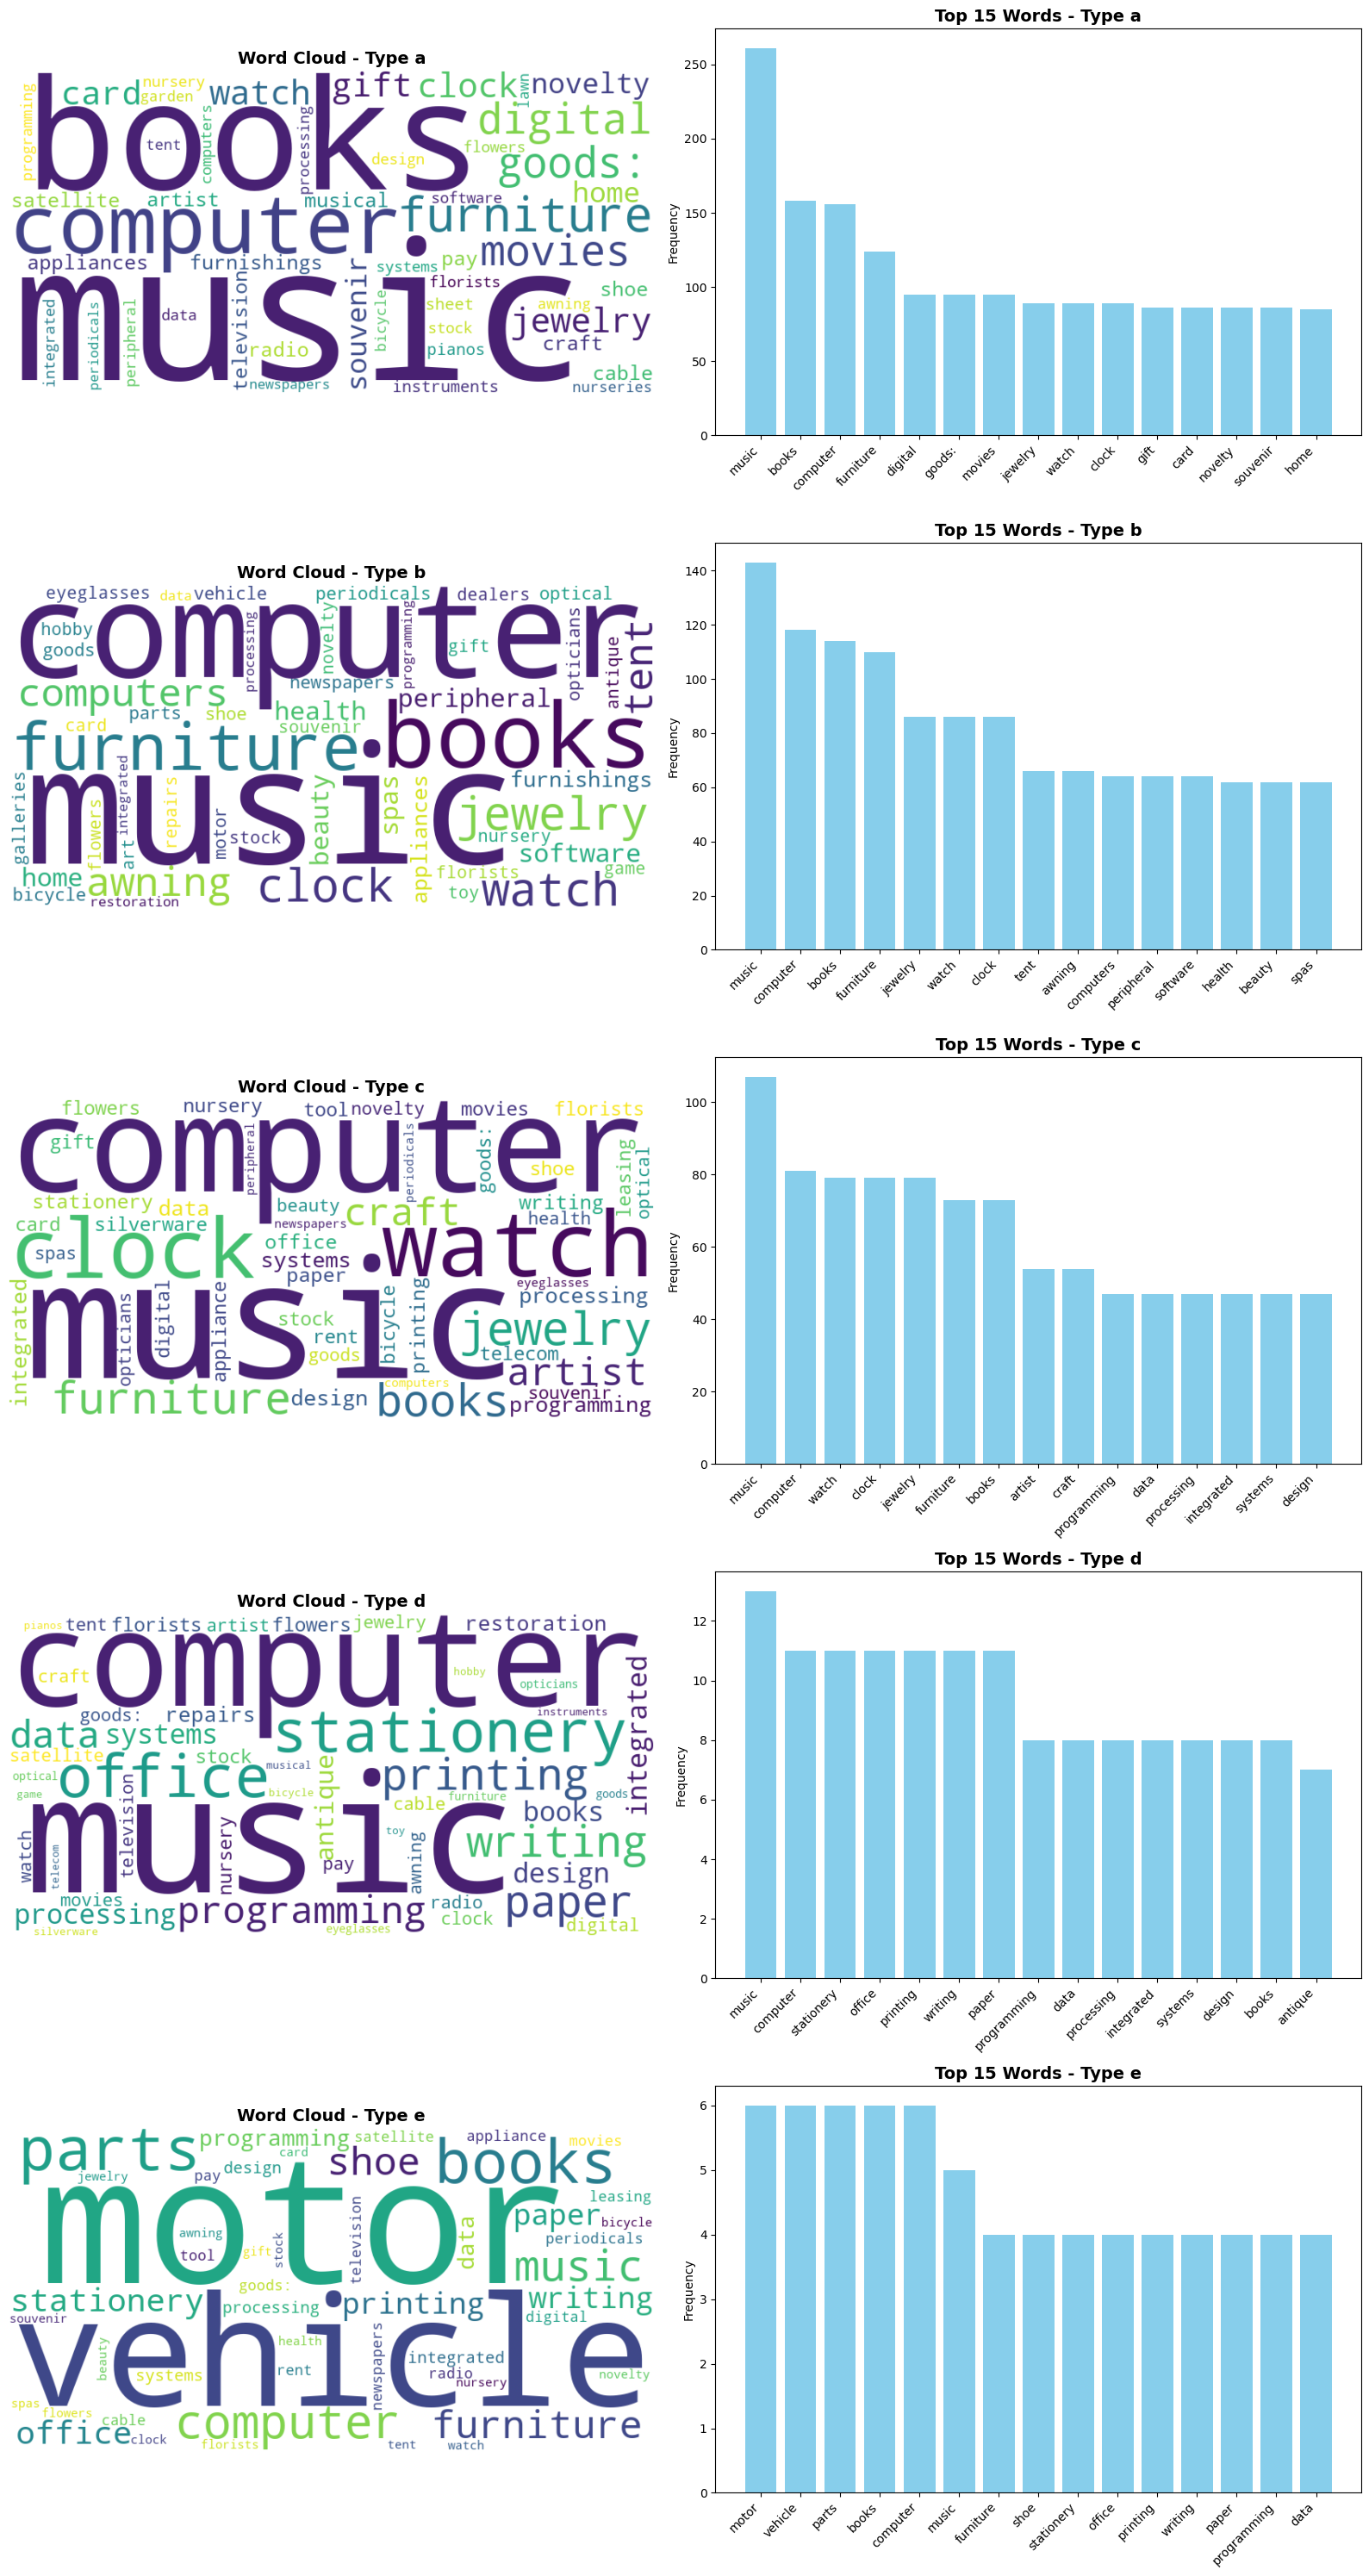

In [55]:
# Generate the final word clouds using the fixed functions
merchant_types = sorted(merchant_feat['type'].unique())

# Create a figure with subplots
fig, axes = plt.subplots(len(merchant_types), 2, figsize=(16, 6 * len(merchant_types)))
if len(merchant_types) == 1:
    axes = axes.reshape(1, -1)

for i, merchant_type in enumerate(merchant_types):
    print(f"Processing Type {merchant_type}...")
    
    # Create word cloud using the fixed function
    result = create_wordcloud_for_type_fixed(merchant_type, merchant_feat)
    
    if result is not None:
        wordcloud, word_freq = result
        
        # Plot word cloud
        axes[i, 0].imshow(wordcloud, interpolation='bilinear')
        axes[i, 0].set_title(f'Word Cloud - Type {merchant_type}', fontsize=14, fontweight='bold')
        axes[i, 0].axis('off')
        
        # Plot top words bar chart
        top_words = dict(word_freq.most_common(15))
        if top_words:
            axes[i, 1].bar(range(len(top_words)), list(top_words.values()), color='skyblue')
            axes[i, 1].set_xticks(range(len(top_words)))
            axes[i, 1].set_xticklabels(list(top_words.keys()), rotation=45, ha='right')
            axes[i, 1].set_title(f'Top 15 Words - Type {merchant_type}', fontsize=14, fontweight='bold')
            axes[i, 1].set_ylabel('Frequency')
        
        # Print some statistics
        type_count = len(merchant_feat[merchant_feat['type'] == merchant_type])
        unique_words = len(word_freq)
        print(f"  - {type_count} merchants")
        print(f"  - {unique_words} unique words")
        print(f"  - Top 5 words: {list(word_freq.most_common(5))}")
    else:
        axes[i, 0].text(0.5, 0.5, f'No data for Type {merchant_type}', 
                       ha='center', va='center', transform=axes[i, 0].transAxes)
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

### Word Cloud Analysis Summary

The word clouds reveal interesting patterns across different merchant types:

### Type A (1,602 merchants)
- **Dominant categories**: Music, books, computer, furniture, digital
- **Business focus**: Entertainment, media, and technology-related businesses
- Most diverse type with strong representation in music and digital goods

### Type B (1,351 merchants) 
- **Dominant categories**: Music, computer, books, furniture, jewelry
- **Business focus**: Similar to Type A but with more emphasis on jewelry and physical goods
- Strong overlap with Type A but slightly more retail-focused

### Type C (922 merchants)
- **Dominant categories**: Music, computer, watch, clock, jewelry
- **Business focus**: Technology and precision goods (timepieces, jewelry)
- More specialized in luxury/precision items compared to other types

### Type D (98 merchants)
- **Dominant categories**: Music, computer, stationery, office, printing
- **Business focus**: Office supplies and business services
- Smallest group, appears to focus on B2B or office-related products

### Type E (53 merchants)
- **Dominant categories**: Motor, vehicle, parts, books, computer
- **Business focus**: Automotive and transportation-related businesses
- Most specialized type, clearly focused on vehicle/automotive sector

### Key Insights:
1. **Music** and **computer** appear across all types, suggesting these are common BNPL categories
2. **Type E** is the most specialized (automotive focus)
3. **Type A** has the broadest category mix and largest merchant count
4. **Types A & B** are similar but Type B leans more toward physical retail
5. **Type C** specializes in precision/luxury goods
6. **Type D** focuses on business/office supplies

## Autocorrelation and Seasonality Analysis

<Axes: xlabel='month'>

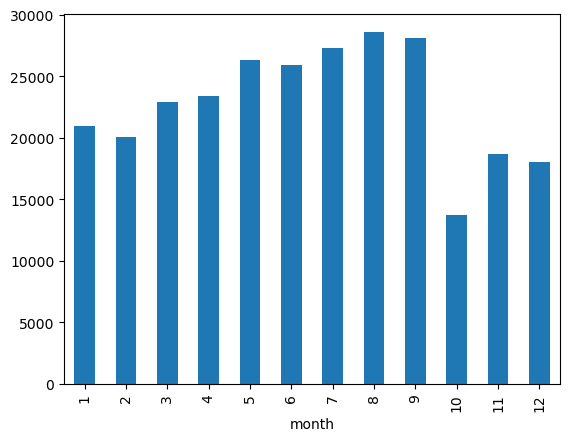

In [56]:
# check for seasonality
seasonality_df = revenue.copy()
seasonality_df['year_month'] = pd.to_datetime(seasonality_df['year_month']).dt.to_period('M')
seasonality_df['month'] = seasonality_df['year_month'].dt.month
seasonality_df.groupby('month')['monthly_revenue'].mean().plot(kind='bar')

Each merchant must be analyzed separately to avoid mixing time series.

Data structure analysis:
Total rows: 88572
Unique merchants: 4026
Unique time periods: 22
Time range: 2021-03 to 2022-12

Observations per merchant:
Min: 22, Max: 22, Mean: 22.0


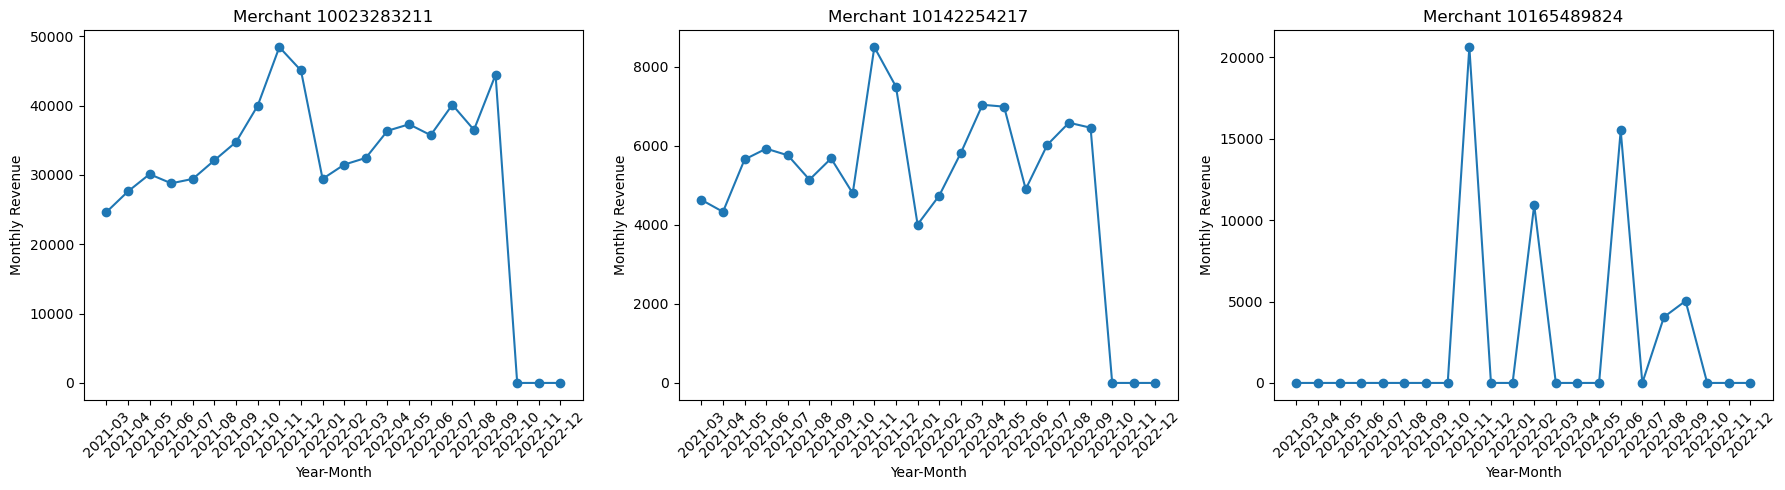

In [58]:
# Method 1: Proper autocorrelation analysis for panel data
# We must analyze each merchant separately, not mix them together

print("WARNING: Never calculate autocorrelation on stacked panel data!")
print("Each merchant must be analyzed separately to avoid mixing time series.\n")

# Let's first understand our data structure
print("Data structure analysis:")
print(f"Total rows: {len(revenue)}")
print(f"Unique merchants: {revenue['merchant_abn'].nunique()}")
print(f"Unique time periods: {revenue['year_month'].nunique()}")
print(f"Time range: {revenue['year_month'].min()} to {revenue['year_month'].max()}")

# Check if we have balanced panel (same number of observations per merchant)
obs_per_merchant = revenue.groupby('merchant_abn').size()
print(f"\nObservations per merchant:")
print(f"Min: {obs_per_merchant.min()}, Max: {obs_per_merchant.max()}, Mean: {obs_per_merchant.mean():.1f}")

# Sample a few merchants to show their time series
sample_merchants = revenue['merchant_abn'].unique()[:3]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, merchant in enumerate(sample_merchants):
    merchant_data = revenue[revenue['merchant_abn'] == merchant].sort_values('year_month')
    axes[i].plot(merchant_data['year_month'], merchant_data['monthly_revenue'], 'o-')
    axes[i].set_title(f'Merchant {merchant}')
    axes[i].set_xlabel('Year-Month')
    axes[i].set_ylabel('Monthly Revenue')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [59]:
# Method 2: Per-merchant autocorrelation analysis (CORRECT APPROACH)
# This properly treats each merchant as a separate time series

def calculate_merchant_autocorr(df, merchant_col='merchant_abn', value_col='monthly_revenue', max_lags=6):
    """
    Calculate autocorrelation for each merchant individually
    CRITICAL: Each merchant is treated as a separate time series
    """
    autocorr_results = []
    merchants_processed = 0
    merchants_skipped = 0
    
    for merchant in df[merchant_col].unique():
        # Sort by time for this specific merchant only
        merchant_data = df[df[merchant_col] == merchant].sort_values('year_month').reset_index(drop=True)
        
        if len(merchant_data) >= max_lags + 2:  # Need enough data points for meaningful autocorr
            merchant_revenue = merchant_data[value_col].values
            
            try:
                # Calculate autocorrelations for this merchant's time series only
                merchant_acf = acf(merchant_revenue, nlags=max_lags, fft=True)
                
                for lag in range(1, len(merchant_acf)):
                    autocorr_results.append({
                        'merchant_abn': merchant,
                        'lag': lag,
                        'autocorr': merchant_acf[lag],
                        'n_periods': len(merchant_data)
                    })
                merchants_processed += 1
            except Exception as e:
                print(f"Error processing merchant {merchant}: {e}")
                merchants_skipped += 1
                continue
        else:
            merchants_skipped += 1
    
    print(f"Processed {merchants_processed} merchants, skipped {merchants_skipped} (insufficient data)")
    return pd.DataFrame(autocorr_results)

# Calculate per-merchant autocorrelations (PROPER METHOD)
merchant_autocorr = calculate_merchant_autocorr(revenue, max_lags=6)
print(f"Calculated autocorrelations for {merchant_autocorr['merchant_abn'].nunique()} merchants")
print(f"Total lag-merchant combinations: {len(merchant_autocorr)}")

# Display summary statistics
print("\nSample results:")
merchant_autocorr.head(12)

Processed 4026 merchants, skipped 0 (insufficient data)
Calculated autocorrelations for 4026 merchants
Total lag-merchant combinations: 24156

Sample results:


,merchant_abn,lag,autocorr,n_periods
0,10023283211,1,0.562841,22
1,10023283211,2,0.215420,22
2,10023283211,3,-0.146083,22
3,10023283211,4,-0.090085,22
4,10023283211,5,-0.099086,22
5,10023283211,6,-0.082742,22
6,10142254217,1,0.524542,22
7,10142254217,2,0.098405,22
8,10142254217,3,-0.133613,22
9,10142254217,4,0.021293,22


In [60]:
# Analyze autocorrelation patterns across merchants
autocorr_summary = merchant_autocorr.groupby('lag').agg({
    'autocorr': ['mean', 'median', 'std', 'count']
}).round(4)

autocorr_summary.columns = ['mean_autocorr', 'median_autocorr', 'std_autocorr', 'count']
print("Autocorrelation Summary by Lag (Proper Method - Per Merchant):")
print(autocorr_summary)

# Statistical significance test
print("\nTesting if mean autocorrelations are significantly different from 0:")

for lag in range(1, 7):
    lag_data = merchant_autocorr[merchant_autocorr['lag'] == lag]['autocorr']
    t_stat, p_value = stats.ttest_1samp(lag_data, 0)
    print(f"Lag {lag}: Mean={lag_data.mean():.4f}, t-stat={t_stat:.2f}, p-value={p_value:.2e}, Significant={p_value < 0.001}")

Autocorrelation Summary by Lag (Proper Method - Per Merchant):
     mean_autocorr  median_autocorr  std_autocorr  count
lag                                                     
1           0.3539           0.4275        0.2327   4026
2           0.0846           0.1146        0.1360   4026
3          -0.1191          -0.1411        0.1300   4026
4          -0.1048          -0.1220        0.1361   4026
5          -0.0918          -0.1071        0.1317   4026
6          -0.0625          -0.0706        0.1062   4026

Testing if mean autocorrelations are significantly different from 0:
Lag 1: Mean=0.3539, t-stat=96.48, p-value=0.00e+00, Significant=True
Lag 2: Mean=0.0846, t-stat=39.46, p-value=3.17e-288, Significant=True
Lag 3: Mean=-0.1191, t-stat=-58.14, p-value=0.00e+00, Significant=True
Lag 4: Mean=-0.1048, t-stat=-48.87, p-value=0.00e+00, Significant=True
Lag 5: Mean=-0.0918, t-stat=-44.23, p-value=0.00e+00, Significant=True
Lag 6: Mean=-0.0625, t-stat=-37.32, p-value=5.23e-262, Sign

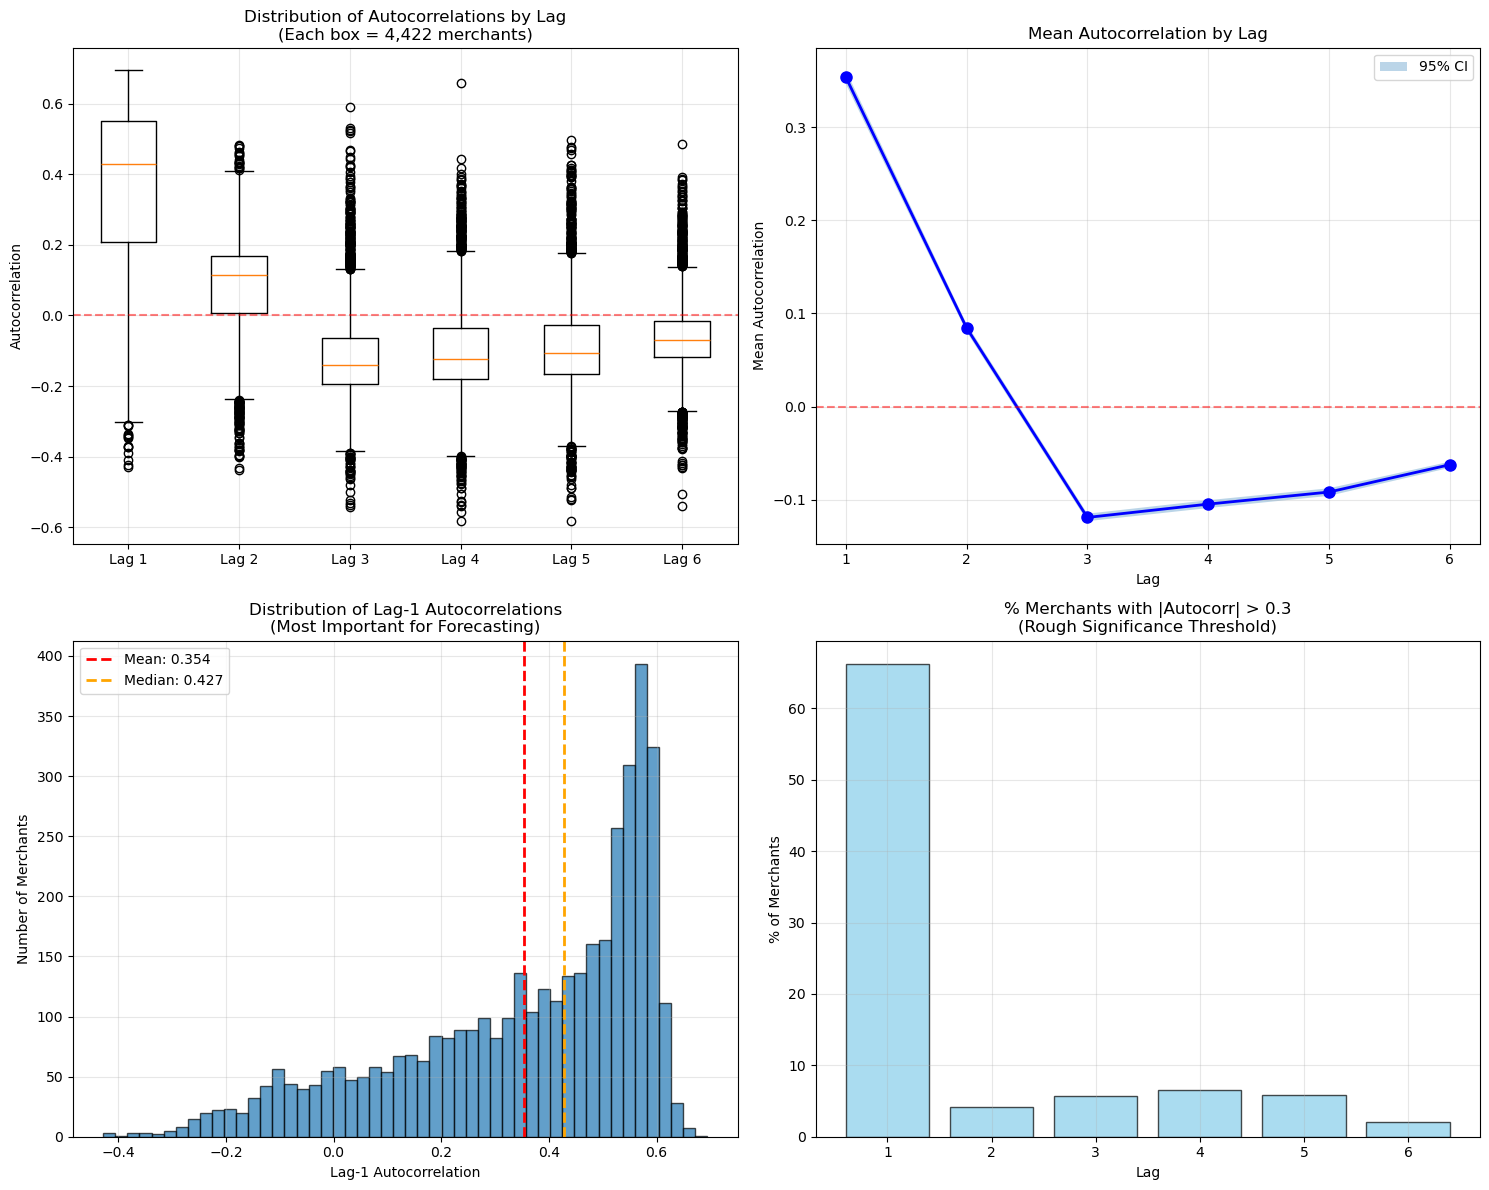

In [61]:
# Visualize autocorrelation patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution of autocorrelations by lag (box plots)
lag_data_for_box = []
lag_labels = []
for lag in range(1, 7):
    lag_values = merchant_autocorr[merchant_autocorr['lag'] == lag]['autocorr']
    lag_data_for_box.append(lag_values)
    lag_labels.append(f'Lag {lag}')

axes[0, 0].boxplot(lag_data_for_box, labels=lag_labels)
axes[0, 0].set_title('Distribution of Autocorrelations by Lag\n(Each box = 4,422 merchants)')
axes[0, 0].set_ylabel('Autocorrelation')
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].grid(True, alpha=0.3)

# 2. Mean autocorrelation by lag
mean_autocorr_by_lag = merchant_autocorr.groupby('lag')['autocorr'].mean()
axes[0, 1].plot(mean_autocorr_by_lag.index, mean_autocorr_by_lag.values, 'bo-', linewidth=2, markersize=8)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Mean Autocorrelation by Lag')
axes[0, 1].set_xlabel('Lag')
axes[0, 1].set_ylabel('Mean Autocorrelation')
axes[0, 1].grid(True, alpha=0.3)

# Add confidence intervals
std_autocorr_by_lag = merchant_autocorr.groupby('lag')['autocorr'].std()
n_merchants = merchant_autocorr.groupby('lag')['autocorr'].count()
se_autocorr = std_autocorr_by_lag / np.sqrt(n_merchants)
ci_95 = 1.96 * se_autocorr
axes[0, 1].fill_between(mean_autocorr_by_lag.index, 
                       mean_autocorr_by_lag - ci_95, 
                       mean_autocorr_by_lag + ci_95, 
                       alpha=0.3, label='95% CI')
axes[0, 1].legend()

# 3. Histogram of Lag 1 autocorrelations (most important)
lag1_data = merchant_autocorr[merchant_autocorr['lag'] == 1]['autocorr']
axes[1, 0].hist(lag1_data, bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(lag1_data.mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {lag1_data.mean():.3f}')
axes[1, 0].axvline(lag1_data.median(), color='orange', linestyle='--', linewidth=2,
                  label=f'Median: {lag1_data.median():.3f}')
axes[1, 0].set_title('Distribution of Lag-1 Autocorrelations\n(Most Important for Forecasting)')
axes[1, 0].set_xlabel('Lag-1 Autocorrelation')
axes[1, 0].set_ylabel('Number of Merchants')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Proportion of merchants with significant autocorrelation
# Critical values for significance (approximately ±0.3 for n=19)
critical_value = 0.3  # Rough approximation for n=19
significant_counts = []
lag_numbers = []

for lag in range(1, 7):
    lag_values = merchant_autocorr[merchant_autocorr['lag'] == lag]['autocorr']
    significant = (np.abs(lag_values) > critical_value).sum()
    prop_significant = significant / len(lag_values) * 100
    significant_counts.append(prop_significant)
    lag_numbers.append(lag)

axes[1, 1].bar(lag_numbers, significant_counts, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].set_title(f'% Merchants with |Autocorr| > {critical_value}\n(Rough Significance Threshold)')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('% of Merchants')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Simple Autocorrelation Check

In [63]:
def calculate_autocorrelation_by_abn(df, max_lag=12):
    """
    Calculate autocorrelation for monthly revenue for each merchant ABN separately
    
    Parameters:
    df: DataFrame with columns ['merchant_abn', 'year_month', 'monthly_revenue']
    max_lag: Maximum lag for autocorrelation calculation
    
    Returns:
    Dictionary with ABN as key and autocorrelation array as value
    """
    
    # Ensure the dataframe is sorted by ABN and then by year_month
    df_sorted = df.sort_values(['merchant_abn', 'year_month']).copy()
    
    # Dictionary to store autocorrelation results for each ABN
    autocorr_results = {}
    
    # Get unique ABNs
    unique_abns = df_sorted['merchant_abn'].unique()
    
    print(f"Processing {len(unique_abns)} unique merchant ABNs...")
    
    for abn in unique_abns:
        # Filter data for current ABN
        abn_data = df_sorted[df_sorted['merchant_abn'] == abn]['monthly_revenue'].values
        
        # Only calculate autocorrelation if we have enough data points
        if len(abn_data) > max_lag + 1:
            try:
                # Calculate autocorrelation with specified max lag
                # nlags parameter includes lag 0, so we use max_lag to get lags 0 to max_lag
                autocorr = acf(abn_data, nlags=max_lag, fft=True)
                autocorr_results[abn] = autocorr
            except Exception as e:
                print(f"Warning: Could not calculate autocorrelation for ABN {abn}: {e}")
                continue
        else:
            print(f"Warning: ABN {abn} has insufficient data points ({len(abn_data)}) for lag {max_lag}")
    
    print(f"Successfully calculated autocorrelation for {len(autocorr_results)} ABNs")
    return autocorr_results

def aggregate_autocorrelations(autocorr_results):
    """
    Aggregate autocorrelations across all ABNs using mean absolute autocorrelation
    
    Parameters:
    autocorr_results: Dictionary with ABN as key and autocorrelation array as value
    
    Returns:
    Array of mean absolute autocorrelations for each lag
    """
    
    if not autocorr_results:
        raise ValueError("No autocorrelation results to aggregate")
    
    # Get the number of lags (should be consistent across all ABNs)
    n_lags = len(next(iter(autocorr_results.values())))
    
    # Initialize array to store all autocorrelations
    all_autocorrs = np.zeros((len(autocorr_results), n_lags))
    
    # Fill the array with autocorrelation values
    for i, autocorr in enumerate(autocorr_results.values()):
        all_autocorrs[i, :] = autocorr
    
    # Calculate mean absolute autocorrelation for each lag
    # We take absolute values before averaging to get the mean absolute autocorrelation
    mean_abs_autocorr = np.mean(np.abs(all_autocorrs), axis=0)
    
    return mean_abs_autocorr, all_autocorrs

def plot_autocorrelation_results(mean_abs_autocorr, all_autocorrs, max_lag=12):
    """
    Plot the aggregated autocorrelation results
    """
    
    lags = np.arange(len(mean_abs_autocorr))
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Mean Absolute Autocorrelation by Lag
    ax1.plot(lags, mean_abs_autocorr, 'b-o', linewidth=2, markersize=8, label='Mean Absolute Autocorrelation')
    ax1.set_xlabel('Lag (months)')
    ax1.set_ylabel('Mean Absolute Autocorrelation')
    ax1.set_title('Mean Absolute Autocorrelation of Monthly Revenue by Lag')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, max_lag)
    ax1.legend()
    
    # Add value labels on points
    for i, v in enumerate(mean_abs_autocorr):
        ax1.annotate(f'{v:.3f}', (i, v), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Plot 2: Individual ABN autocorrelations (first few for visualization)
    n_to_plot = min(10, all_autocorrs.shape[0])  # Plot max 10 ABNs for clarity
    for i in range(n_to_plot):
        ax2.plot(lags, all_autocorrs[i, :], alpha=0.5, linewidth=1)
    
    # Overlay the mean
    ax2.plot(lags, np.mean(all_autocorrs, axis=0), 'r-', linewidth=3, 
             label=f'Mean Autocorrelation (n={all_autocorrs.shape[0]} ABNs)')
    ax2.set_xlabel('Lag (months)')
    ax2.set_ylabel('Autocorrelation')
    ax2.set_title('Individual ABN Autocorrelations with Mean Overlay')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, max_lag)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*50)
    print("AUTOCORRELATION ANALYSIS SUMMARY")
    print("="*50)
    print(f"Number of ABNs analyzed: {all_autocorrs.shape[0]}")
    print(f"Maximum lag analyzed: {max_lag}")
    print(f"\nMean Absolute Autocorrelation by Lag:")
    print("-" * 40)
    for i, val in enumerate(mean_abs_autocorr):
        print(f"Lag {i:2d}: {val:.4f}")

def analyze_revenue_autocorrelation(df, max_lag=12):
    """
    Main function to perform complete autocorrelation analysis
    
    Parameters:
    df: DataFrame with columns ['merchant_abn', 'year_month', 'monthly_revenue']
    max_lag: Maximum lag for autocorrelation analysis
    """
    
    print("Starting Revenue Autocorrelation Analysis")
    print("="*50)
    
    # Step 1: Calculate autocorrelation for each ABN
    print("\nStep 1: Calculating autocorrelation for each merchant ABN...")
    autocorr_results = calculate_autocorrelation_by_abn(df, max_lag)
    
    if not autocorr_results:
        print("Error: No valid autocorrelation results obtained. Please check your data.")
        return None, None
    
    # Step 2: Aggregate autocorrelations
    print("\nStep 2: Aggregating autocorrelations across all ABNs...")
    mean_abs_autocorr, all_autocorrs = aggregate_autocorrelations(autocorr_results)
    
    # Step 3: Plot results
    print("\nStep 3: Plotting results...")
    plot_autocorrelation_results(mean_abs_autocorr, all_autocorrs, max_lag)
    
    return mean_abs_autocorr, all_autocorrs

Starting Revenue Autocorrelation Analysis

Step 1: Calculating autocorrelation for each merchant ABN...
Processing 4026 unique merchant ABNs...
Successfully calculated autocorrelation for 4026 ABNs

Step 2: Aggregating autocorrelations across all ABNs...

Step 3: Plotting results...


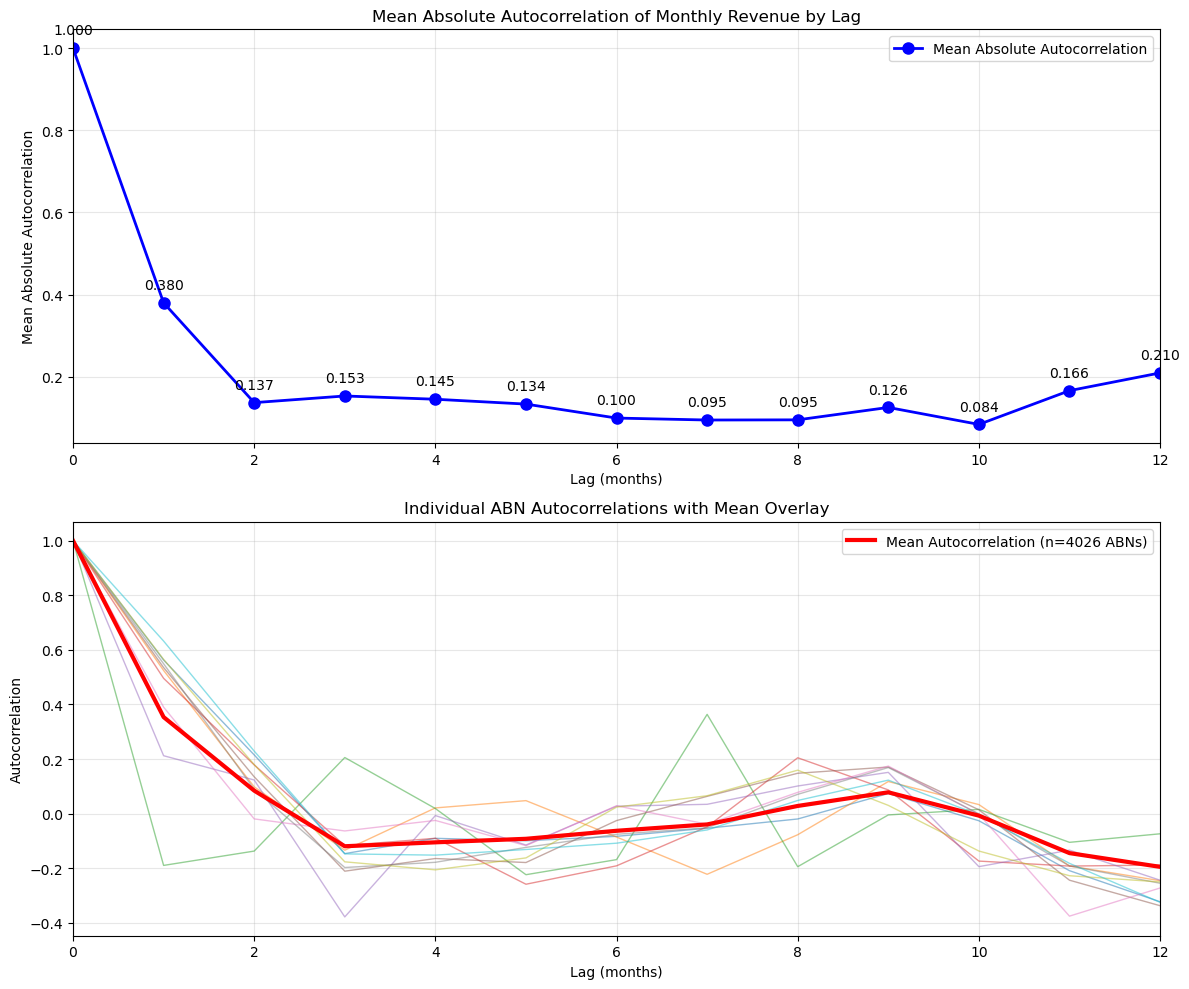


AUTOCORRELATION ANALYSIS SUMMARY
Number of ABNs analyzed: 4026
Maximum lag analyzed: 12

Mean Absolute Autocorrelation by Lag:
----------------------------------------
Lag  0: 1.0000
Lag  1: 0.3802
Lag  2: 0.1372
Lag  3: 0.1534
Lag  4: 0.1455
Lag  5: 0.1337
Lag  6: 0.0997
Lag  7: 0.0949
Lag  8: 0.0953
Lag  9: 0.1255
Lag 10: 0.0842
Lag 11: 0.1664
Lag 12: 0.2095


25/10/03 19:20:53 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 170132 ms exceeds timeout 120000 ms
25/10/03 19:20:53 WARN SparkContext: Killing executors is not supported by current scheduler.
25/10/03 19:20:58 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [64]:
# Run the analysis
mean_abs_autocorr, all_autocorrs = analyze_revenue_autocorrelation(revenue, max_lag=12)